In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

### Defining Value Class for Neural Network

In [14]:
class Value():
    def __init__(self,data,operation=None,_children =(),label=""):
        self.data = data
        self.grad = 0.0
        self.label = label
        self.operation = operation
        self._backprop = lambda: None
        self.children = set(_children)
        
    def __repr__(self):
        return f"Value:{self.data},label:{self.label}"
        
    def __add__(self,other):
        
        if isinstance(other,(int,float)):
            other = Value(other)
            
        v = Value(self.data+other.data,"+",(self,other))
        # v.label = f"{self.label}{other.label}"
        def backprop():
            self.grad += 1.0*v.grad
            other.grad += 1.0*v.grad
            
        v._backprop = backprop
        return v
    def __sub__(self,other):
        return self+(-1*other)
    
    def __rsub__(self,other):
        return self - other
        
    def __mul__(self,other):
        
        if isinstance(other,(int,float)):
            other = Value(other)
            
        v = Value(self.data*other.data,"*",(self,other))
        # v.label = f"{self.label}{other.label}"
        def backprop():
            self.grad += other.data*v.grad
            other.grad += self.data*v.grad
            
        v._backprop = backprop
        return v
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)),"Only int or float"
        v = Value(self.data**other,"pow",(self,))
        def backprop():
            self.grad += other*(self.data**(other- 1)) * v.grad
        v._backprop = backprop
        return v
    def __rmul__(self,other):  
        return self*other

    def __radd__(self,other):
        return self+other
        
    def __truediv__(self,other):
        if isinstance(other,(int,float)):
            other = Value(other)
        return self * (other.data**-1)
        
    def __rtruediv__(self,other):
        if isinstance(other,(int,float)):
            other = Value(other)
        return ((self.data)**-1) * other 
        
    def tanh(self):
        tanh = (np.exp(2*self.data) - 1)/(np.exp(2*self.data) +1)
        v = Value(tanh,"tanh",(self,))
        
        def backprop():
            self.grad += (1 - (tanh**2)) * v.grad
        
        v._backprop = backprop
        return v
            
    def backprop(self):
        def topological_sort(root,sorted_graph):            
            
            # for x in root.children:
            #     if x not in sorted_graph:
            #         sorted_graph.append(x)
            
            if root not in sorted_graph:
                for x in root.children:
                    topological_sort(x,sorted_graph)
                
                
                sorted_graph.append(root)
            return sorted_graph
        
        topo_list = topological_sort(self,[])
        self.grad = 1
        for x in topo_list[::-1]:
            x._backprop()

### Example operation of forward and backward pass with graph visualization

In [15]:
a = Value(1.0,label="a")
a1 = Value(1.5,label="a1")
b = Value(1.75,label="b")
c = b * a1;c.label = "c";
d = Value(1.25,label="d")
e = a * b;e.label = "e";
f = c + e;f.label = "f";
g = d * f;g.label = "g";
o = g.tanh();o.label = "l"

In [16]:
import graphviz as graph 

In [17]:
def draw_nn(root: Value,dot):
    dot.node(root.label,label = "{ %s | data %.4f | grad %.4f }" % (root.label, root.data, root.grad), shape='record')
    
    if root.operation != None:
        dot.node(root.operation+root.label,label =root.operation)
        dot.edge(root.operation+root.label,root.label)
    if root.children != None:
        for x in root.children:
            dot.node(x.label)
            dot.edge(x.label,root.operation+root.label)
            draw_nn(x,dot)
    return dot
    

In [18]:
o.backprop()

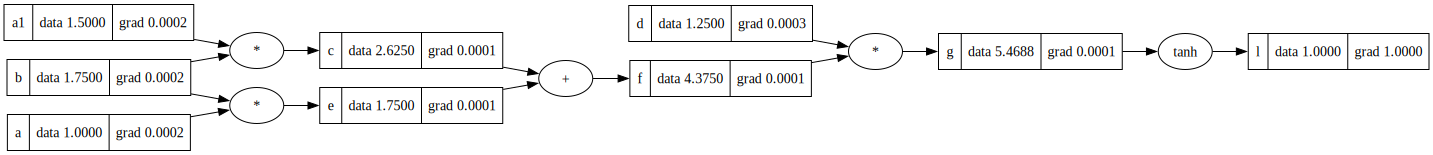

In [19]:
dot = graph.Digraph("nn",graph_attr={'rankdir': 'LR'},node_attr={"orientation":"270"})
draw_nn(o,dot)

### Defining Neuron,Layers and Neural Network classes to build a Multi-layer preceptron

In [20]:
class Neuron:
    def __init__(self,nin,layer=0):
        self.W = [Value(x) for x in np.random.normal(size=nin)]
        self.layer = layer
        # for i,v in enumerate(self.W):
        #     v.label = f"w{layer}{i}"
        self.b = Value(np.random.normal(size=1)[0],label=f"biasL{layer}")

    def __call__(self,X):
        out = sum((w*x for w,x in zip(self.W,X)),self.b)
        out = out.tanh()
        return out

    def parameters(self):
        return (self.W + [self.b])

class Layer:
    def __init__(self,nin,n,layer = 0):
        self.layer = layer
        self.neurons = [Neuron(nin,layer) for x in range(n)]
        
    def __call__(self,X):
        layer_out = []
        for i,n in enumerate(self.neurons):
            out = n(X)
            out.label = f"N{self.layer}{i}"
            layer_out.append(out)        

        return layer_out[0] if len(layer_out)==1 else layer_out
        
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class NeuralNet:
    def __init__(self,nin,layer_spec : list):
        self.nin = nin
        self.nlayers = layer_spec
        self.layerspec = [nin] + layer_spec
        self.layers=[Layer(self.layerspec[x],self.layerspec[x+1],layer=x) for x in range(len(self.layerspec)-1)]
    def __call__(self,x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out
        
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

    def _loss(self,ytest,ypred):
        return sum((yout - ygt)**2 for ygt, yout in zip(ytest, ypred))

    def _sgd(self):
        for p in nn.parameters():
            p.data += -0.1 * p.grad

    def train(self,xtrain,ytrain,iteration = 20):
        for k in range(iteration):
        
            # forward pass
            ypred = [self(x) for x in xtrain]
            loss = self._loss(ytrain, ypred)
            
            # backward pass
            for p in self.parameters():
                p.grad = 0.0
            loss.backprop()
            
            # update
            self._sgd()
        
            print(k, loss.data)

    def test(self,xtest,ytest):
        ypred = [self(x) for x in xtest]
        loss = self._loss(ytest,ypred)
        return ypred,loss
    

In [21]:
nn = NeuralNet(3, [4, 4, 1])

In [22]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [23]:
nn.train(xs,ys,25)

0 5.66168247502081
1 4.222802355455099
2 3.947220989388287
3 3.934317289026516
4 3.912529244799857
5 3.8681042321480024
6 3.738411498109155
7 2.898114241095988
8 0.024072267617280967
9 0.021984829538240682
10 0.020329486298663057
11 0.01897147067912205
12 0.01782882407499778
13 0.016848669948273363
14 0.01599514293780316
15 0.015242867632744928
16 0.014573245748374288
17 0.013972240229837661
18 0.013428995101837322
19 0.012934942112713257
20 0.012483202195967349
21 0.012068171996273124
22 0.011685230429893872
23 0.011330525444933421
24 0.011000815817025169


In [24]:
nn.test(xs,ys)

([Value:0.9556844438341989,label:N20,
  Value:-0.9977773248928435,label:N20,
  Value:-0.9171044516702833,label:N20,
  Value:0.9569550131791187,label:N20],
 Value:0.010693351626210483,label:)